In [1]:
initialized = False

In [2]:
import os
if(initialized == False):
    os.chdir('..')
    initialized = True

In [3]:
import nux.flows as nux
import haiku as hk
import jax
from jax import random, vmap, jit
import jax.numpy as jnp
from jax.experimental import optimizers
import tensorflow_datasets as tfds
import tensorflow as tf
import tqdm
from functools import partial
import nux.util as util
import matplotlib.pyplot as plt
from nux.training import ImageGenerativeModel

# Create the GLOW network

In [4]:
def GLOWBlock():
    return nux.sequential(nux.ActNorm(),
                          nux.OnebyOneConv(),
                          nux.Coupling(n_channels=128))

def GLOW(num_blocks=4):
    layers = [GLOWBlock() for _ in range(num_blocks)]
    return nux.sequential(*layers)

def MultiscaleGLOW(quantize_bits=3):
    flow = nux.Identity()
    flow = nux.multi_scale(GLOW(), flow)
    flow = nux.multi_scale(GLOW(), flow)

    flow = nux.sequential(nux.UniformDequantization(scale=2**quantize_bits),
                          nux.Logit(),
                          flow,
                          nux.Flatten(),
                          nux.UnitGaussianPrior())
    return flow

# Load the dataset

In [5]:
def central_crop(x):
    x['image'] = x['image'][::2,::2][26:-19,12:-13]
    return x

def quantize(x, quantize_bits):
    quantize_factor = 256/(2**quantize_bits)
    x['image'] = x['image']//tf.cast(quantize_factor, dtype=tf.uint8)
    return x

def load_dataset(split='train', is_training=True, n_batches=1000, batch_size=32, quantize_bits=3):
    ds = tfds.load('celeb_a', split=split).repeat()
    ds = ds.map(central_crop)
    ds = ds.map(partial(quantize, quantize_bits=quantize_bits))
    if is_training:
        ds = ds.shuffle(10*batch_size, seed=0)
    ds = ds.batch(batch_size).batch(n_batches) # The trainer object expects many data batches at once!
    return tfds.as_numpy(ds)

# Initialize the model using a trainer object

In [6]:
quantize_bits = 3
ds = load_dataset(quantize_bits=quantize_bits)

x = next(ds)['image'][0]
inputs = {'x': x}

key = random.PRNGKey(0)
init_fun = MultiscaleGLOW(quantize_bits=quantize_bits)

outputs, flow = init_fun(key, inputs, batched=True)
NF = ImageGenerativeModel(flow)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Train with a lax.scan loop by calling multi_grad_step

/home/eddie/anaconda3/envs/flow/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


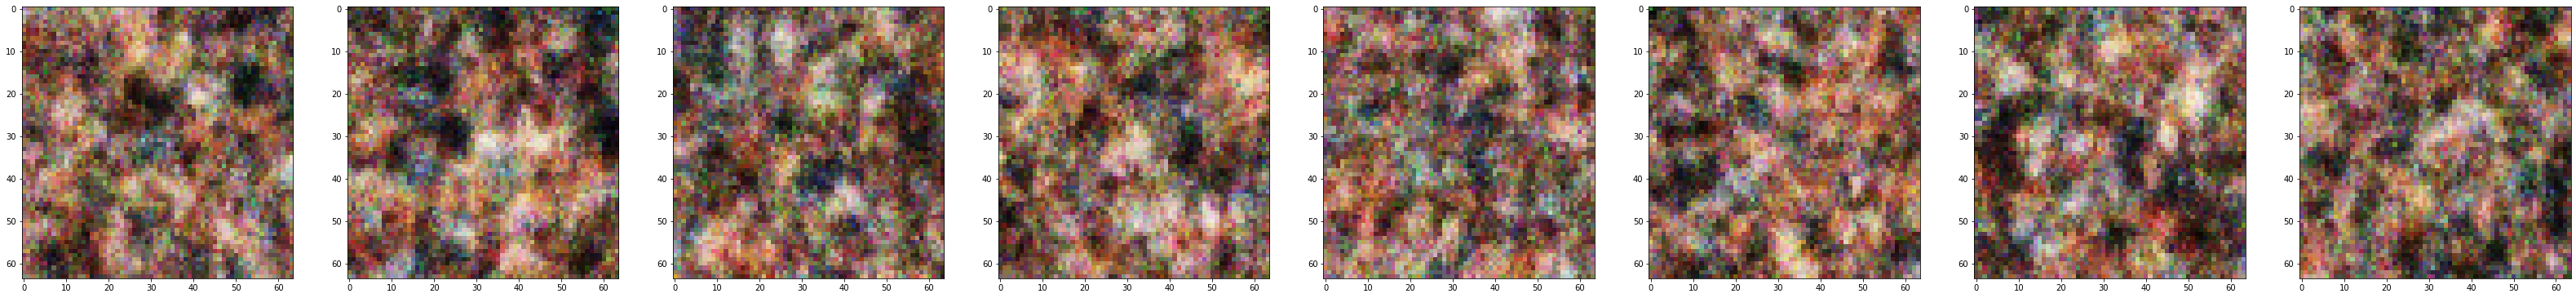

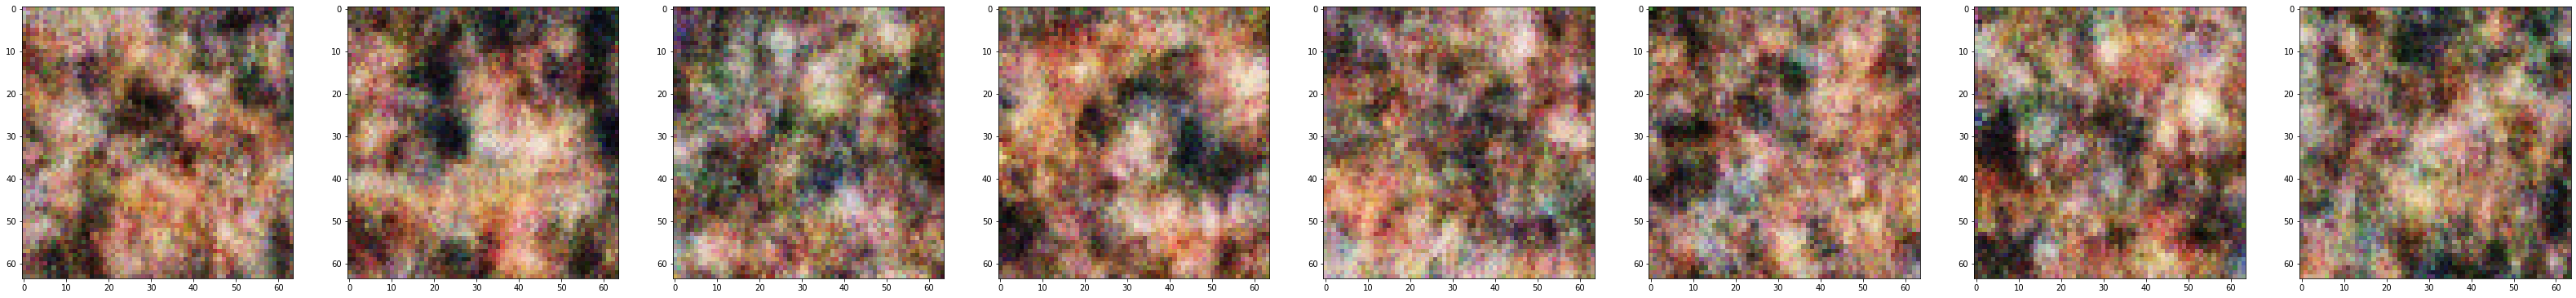

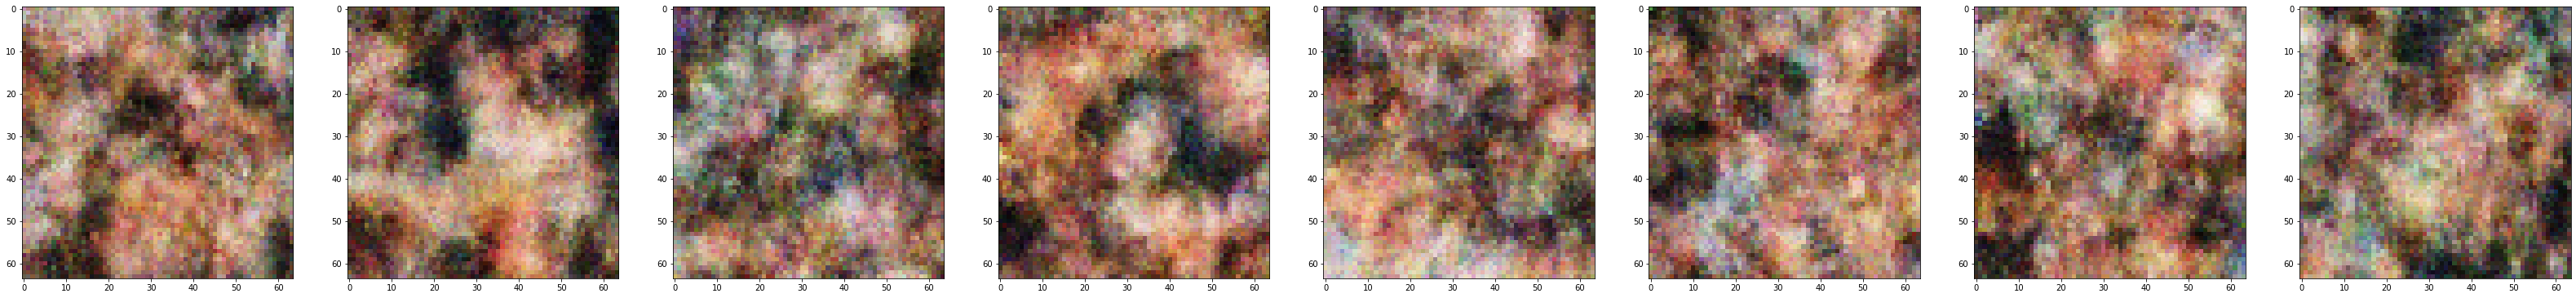

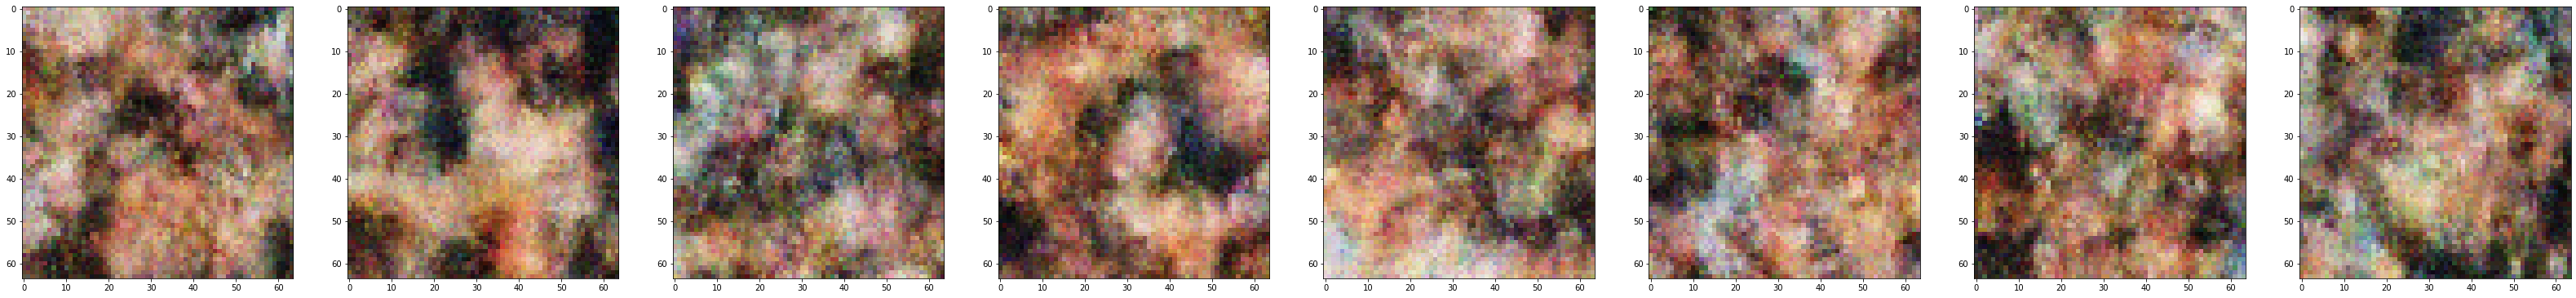

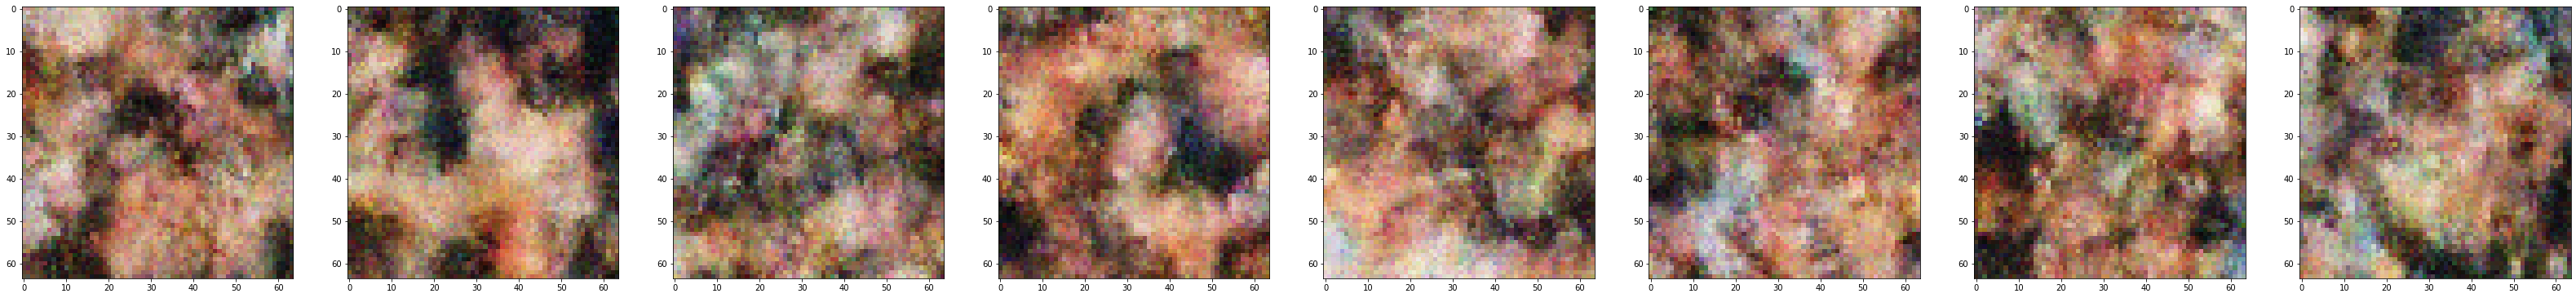

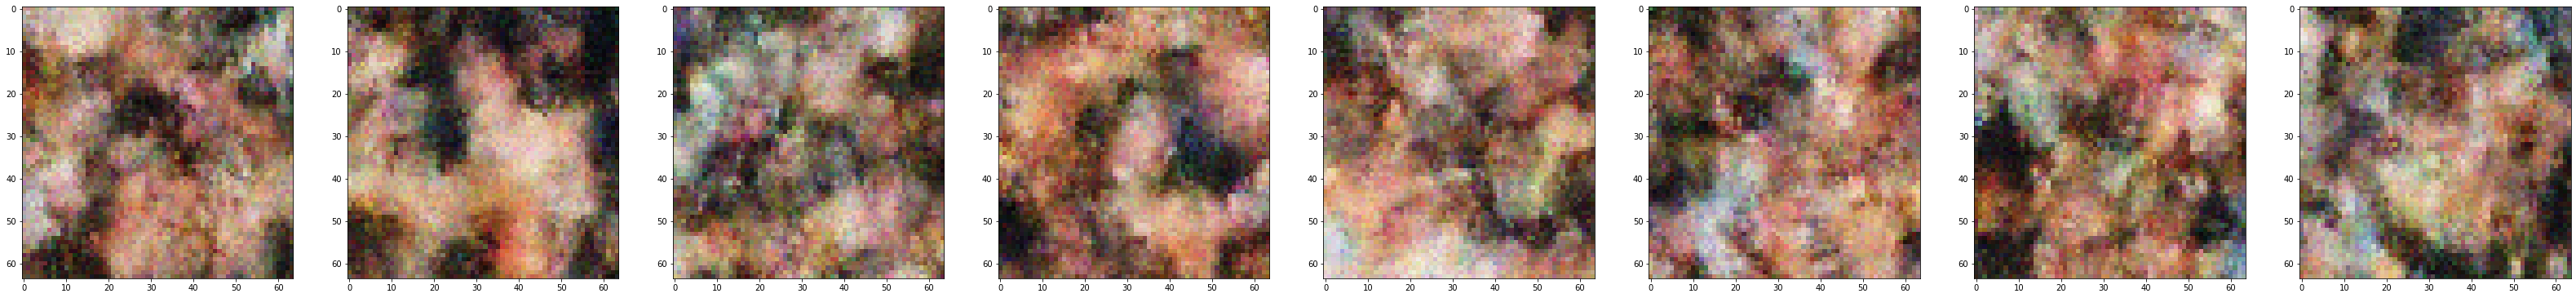

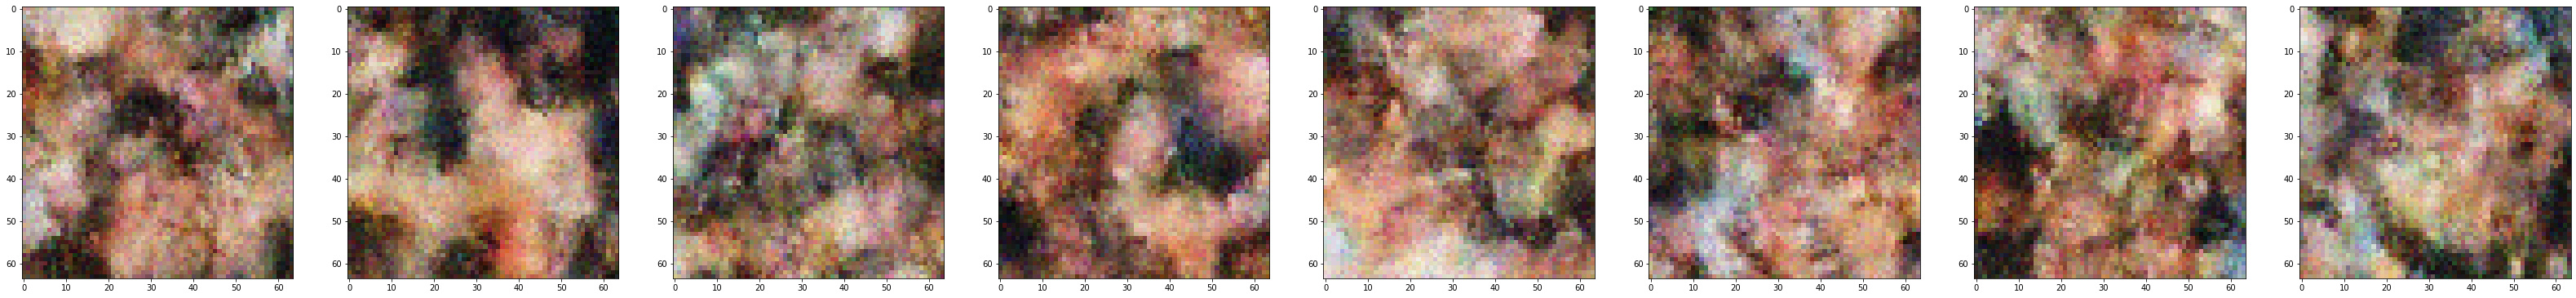

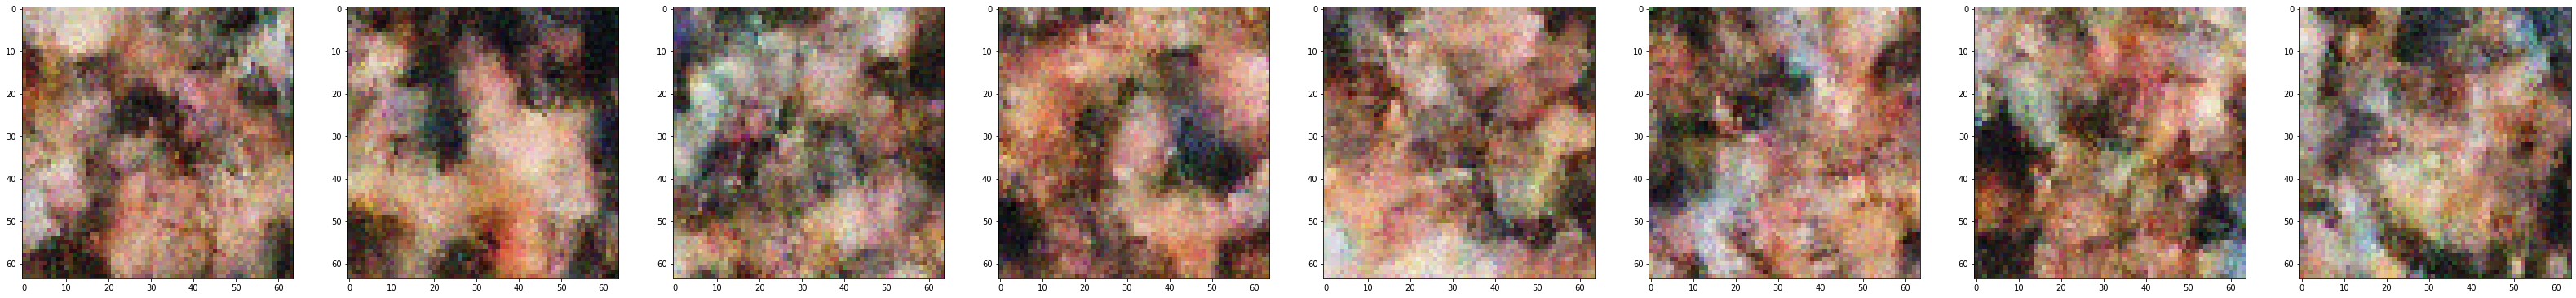

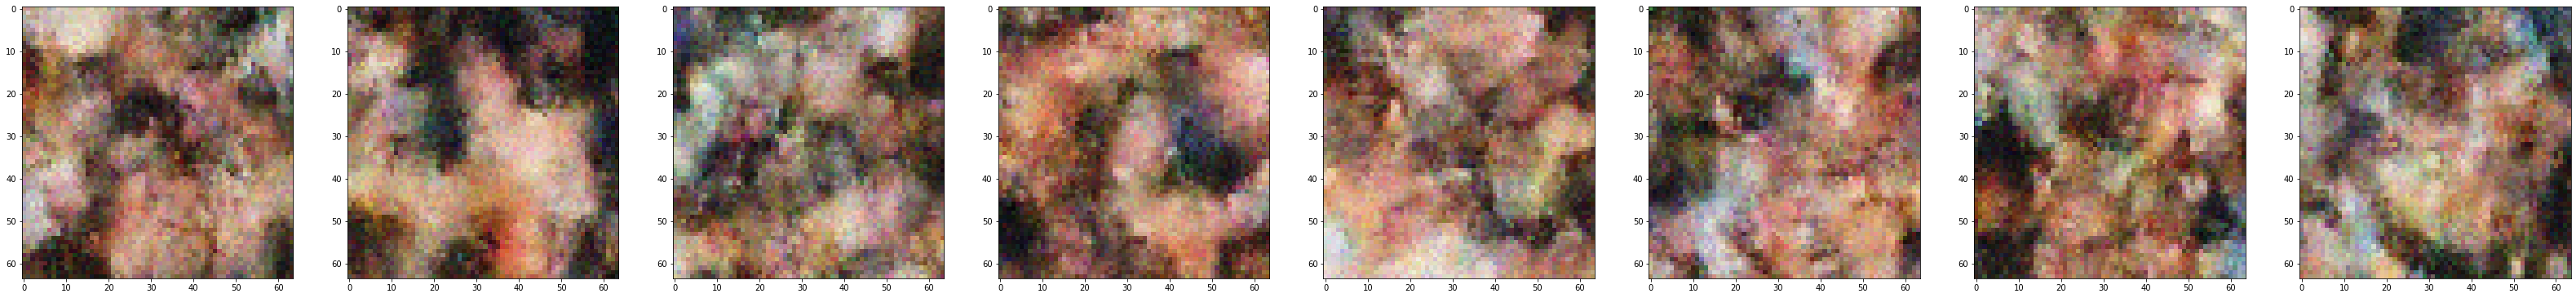

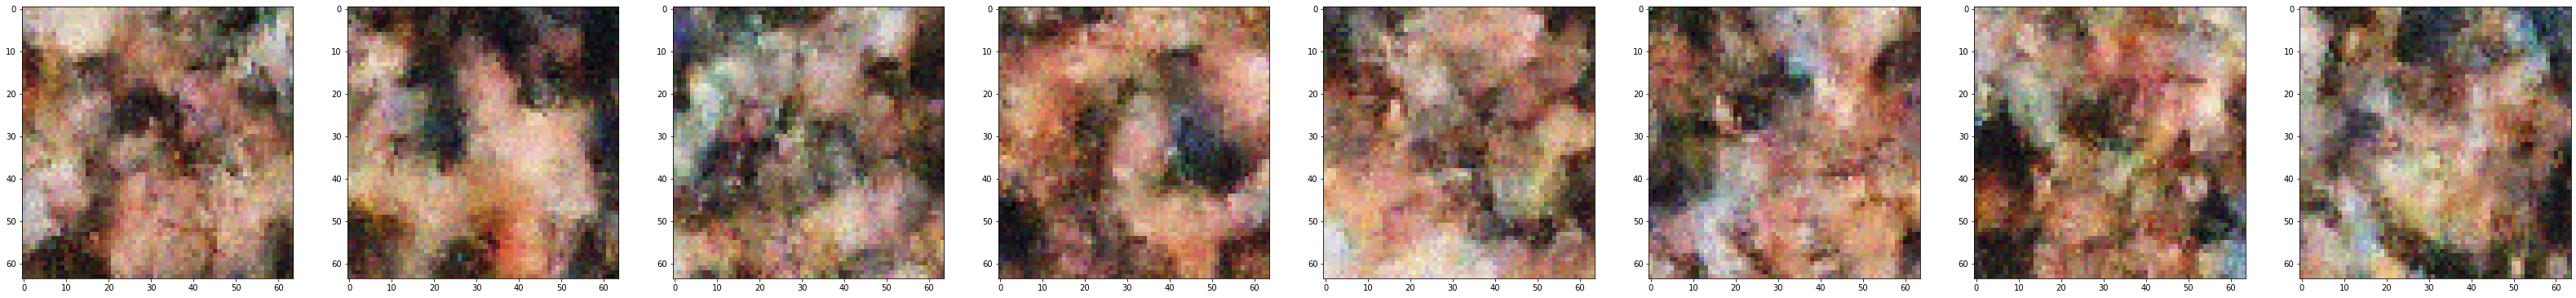

In [7]:
n_iters = 10
key = random.PRNGKey(1)
keys = random.split(key, n_iters)
pbar = tqdm.notebook.tqdm(enumerate(keys), total=n_iters)
for i, key in pbar:
    
    # Take n_batches gradient steps
    nll = NF.multi_grad_step(key, next(ds)['image'])
    
    # Compute the bits/dim loss
    bits_per_dim = nll.mean()/jnp.prod(NF.flow.input_shapes['x'])/jnp.log(2)
    pbar.set_description('bits/dim: %5.3f'%(bits_per_dim))
    
    # Generate some samples
    eval_key = random.PRNGKey(1)
    n_samples = 8

    fz = NF.sample(eval_key, n_samples)

    # Plot the samples
    fig, axes = plt.subplots(1, n_samples, figsize=(7*n_samples, 7)); axes=axes.ravel()
    for i, ax in enumerate(axes):
        ax.imshow(fz[i])
    plt.show()